## Work distribution

Nose-balanced vs uniform sampling is compared. More detailed description is coming :)

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
from plotoptix import TkOptiX
from plotoptix.materials import m_dispersive_glass, m_mirror

Setup the raytracer using Tkinter GUI as the output target:

In [2]:
def image_ready(rt: TkOptiX) -> None: print("ready!")

rt = TkOptiX(on_rt_accum_done=image_ready, width=1280, height=960, start_now=False)

# keep albedo/normals available also when denoiser is not used
rt.set_param(save_albedo=True, save_normals=True)

rt.set_uint("path_seg_range", 8, 16)

rt.set_background(0)
rt.set_ambient(0)

# we'll need that parameters later to undo gamma corection for the noise vizualisation
exposure = 1.1
gamma = 2.2
rt.set_float("tonemap_exposure", exposure)
rt.set_float("tonemap_gamma", gamma)
rt.add_postproc("Gamma")

Use these parameters for the usual, uniform sampling.

In [3]:
rt.set_param(
             min_accumulation_step=16,
             max_accumulation_frames=256,
             work_distribution="Uniform"
            )

...or use these values for the noise-balanced sampling. Average number of samples per pixel should be the same as uniform sampling, but more samples are directed to noisy pixels.

In [3]:
rt.set_param(
             min_accumulation_step=16,    # how often the noise map is updated in the noise-balanced mode
             max_accumulation_frames=432, # max accumulation steps, a bit more here to collect same average samples/pixel
             work_distribution="NoiseBalanced"
            )

Load mesh, setup scene light and cam:

In [4]:
rt.setup_material("glass", m_dispersive_glass)
rt.setup_material("mirror", m_mirror)

rt.load_mesh_obj("data/utah-teapot-1.obj", mat="glass", c=500)

rt.set_data("sphere",
            pos=[
                [-16, -4.33, -15],
                [-25, -4.33, -10],
                [25, -4.33, 0],
                ],
            r=5, c=0.96, mat="mirror"
           )

rt.set_data("plane", geom="Parallelograms",
            pos=[-100, -9.33, -100], u=[200, 0, 0], v=[0, 0, 200],
            c=[0.71, 0.82, 0.93]
           )

rt.setup_camera("cam1", cam_type="ThinLens",
                eye=[0, 60, 150], target=[1, -3, 0],
                aperture_radius=1.5, fov=15,
                glock=True
               )

rt.setup_area_light("light1",
                    center=[0, 30, -25], target=[0, 0, 0], u=65, v=6,
                    color=[9, 8, 7]
                   )

Start the GUI window and wait for the "ready!" message, telling all the ray-tracing is completed. Here we're reading buffers directly, with no callbacks, for simplicity, thus need to wait for raytracer to complete. Sync on callback is explained in another example.

In [5]:
rt.start()

ready!


SEM error and sample count are stored in unused 4th values of albedo and normals. This will be possible to switch off in configuration in the next release. Note, these values are available only for noise-balanced mode.

0.0 0.013345182 0.18540375


<IPython.core.display.Javascript object>


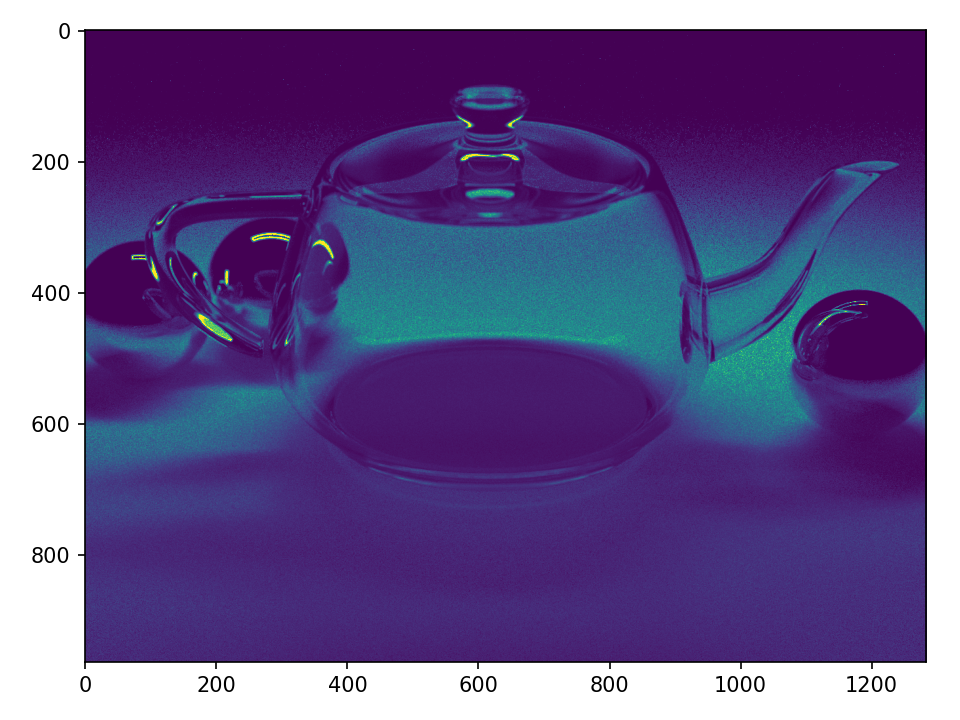

In [6]:
# Absolute sqrt(SEM) value, it is a good metric of the noise, though in practice we need relative noise.
sem = rt._albedo[:,:,3]
print(np.min(sem), np.mean(sem), np.max(sem))

plt.figure(1)
plt.imshow(sem, vmax=0.10)
plt.tight_layout()

0.0 0.13966451234225075 1.000001285194451


<IPython.core.display.Javascript object>


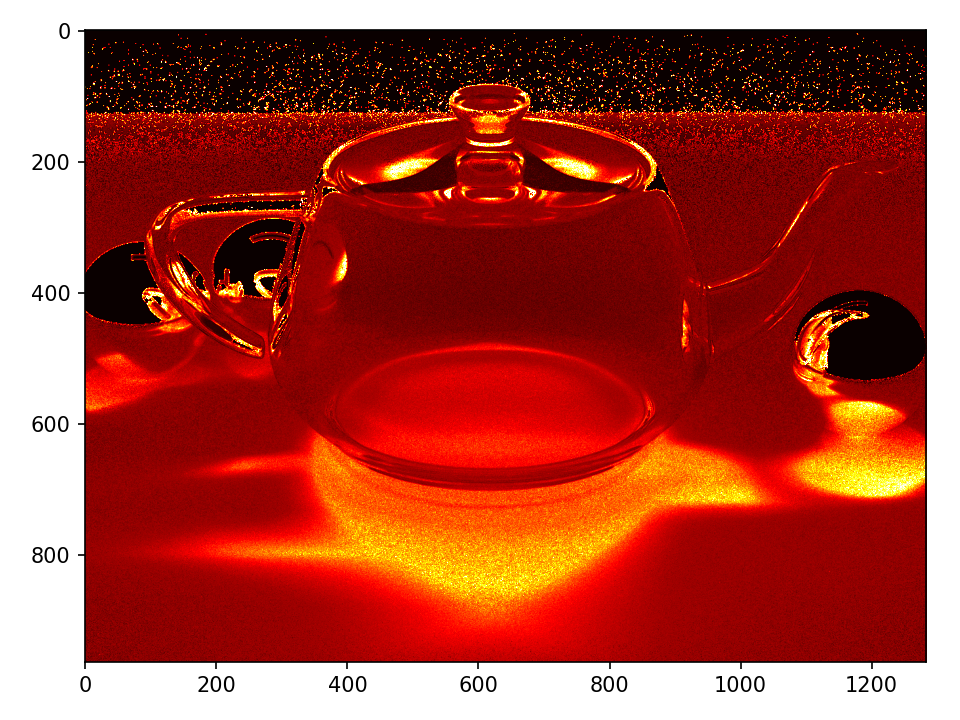

In [7]:
# Relative SEM, used to decide which pixels are sampled more.
ungamma = (1/exposure) * np.power(rt._raw_rgba[:,:,:3], gamma)
grayscale = np.dot(ungamma, [0.299, 0.587, 0.114])
grayscale[grayscale < 0.0001] = 1.0
ratio = sem / grayscale
print(np.min(ratio), np.mean(ratio), np.max(ratio))

plt.figure(2)
plt.imshow(ratio, vmin=0, vmax=0.6, cmap='hot')
plt.tight_layout()

42.0 255.11896 432.0


<IPython.core.display.Javascript object>


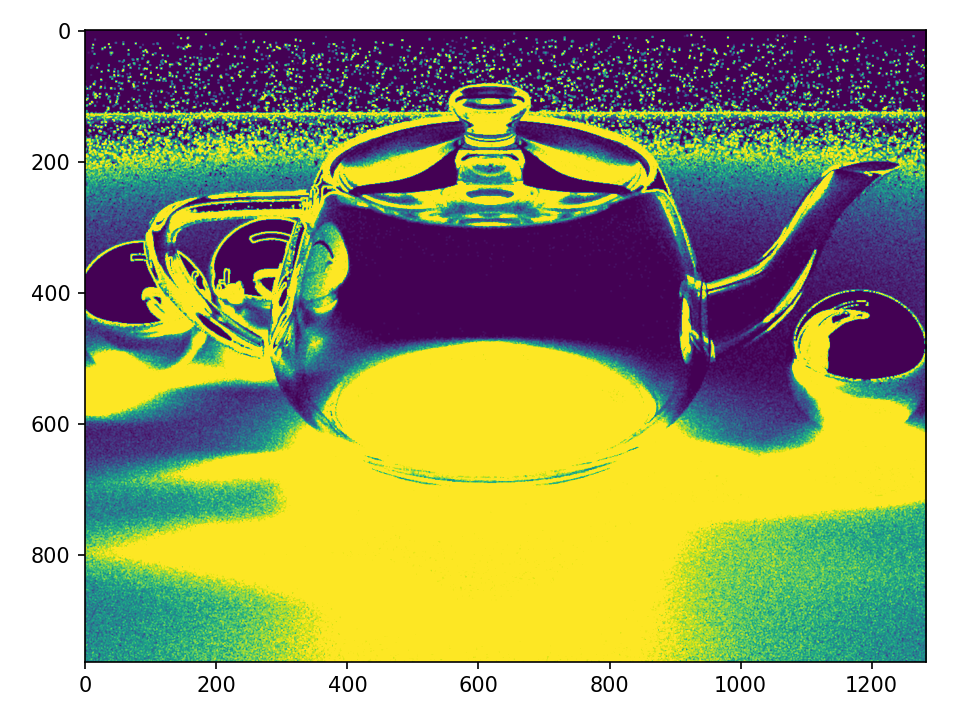

In [8]:
# Samples/pixel count.
count = rt._normal[:,:,3]
print(np.min(count), np.mean(count), np.max(count))

plt.figure(3)
plt.imshow(count)
plt.tight_layout()

Close the ray-tracer.

In [9]:
rt.close()